# Camera Calibration and Distorsion Correction

In [1]:
import math
import numpy as np
import cv2
import glob
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
folder_path = './camera_cal/'
images = glob.glob('./camera_cal/calibration*.jpg')

def camera_calibration(gray_image_data):
    images = np.copy(gray_image_data)
    
    # Step through the list and search for chessboard corners
    for idx, fname in tqdm(enumerate(images)):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            write_name = './camera_cal/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
            #cv2.imshow('img', img)
            #cv2.waitKey(500)

    # Do camera calibration given object points and image points
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
            
    return ret, mtx, dist, rvecs, tvecs

ret, mtx, dist, rvecs, tvecs = camera_calibration(images)

In [ ]:
def distortion_correction(image_data, mtx, dist):
    images = np.copy(image_data)
    for idx, fname in tqdm(enumerate(images)):
        img = cv2.imread(fname)
        #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        cv2.imwrite('./camera_cal/undist'+str(idx)+'.jpg', dst)
        
distortion_correction(images, mtx, dist)

In [ ]:
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
#print(dist_pickle)
pickle.dump( dist_pickle, open( "./camera_cal/calibration_ pickle.p", "wb" ) )

# Canny Edge Detection

In [65]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    # print("mask: ", mask.shape)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
        # print("True")
    else:
        ignore_mask_color = 255
        # print("False")
    
    #ignore_mask_color = 255
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def normaliseColourImages(image):
    img = np.copy(image.astype(np.float32))
    img = cv2.normalize(img, dst=img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return img

## Enhance Contrast using histogram equalization
def enhanceContrastOfImage(img):
    #return cv2.equalizeHist(img)

    yuv_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    yuv_img[:,:,0] = cv2.equalizeHist(np.asarray(yuv_img[:,:,0], np.uint8))
    return cv2.cvtColor(yuv_img, cv2.COLOR_YUV2RGB)

    '''
    if np.mean(img) < 50:
        brightImage = img.copy()
        brightImage[:,:,0] = cv2.equalizeHist(img[:,:,0])
        brightImage[:,:,1] = cv2.equalizeHist(img[:,:,1])
        brightImage[:,:,2] = cv2.equalizeHist(img[:,:,2])
        return brightImage
    return img
    '''

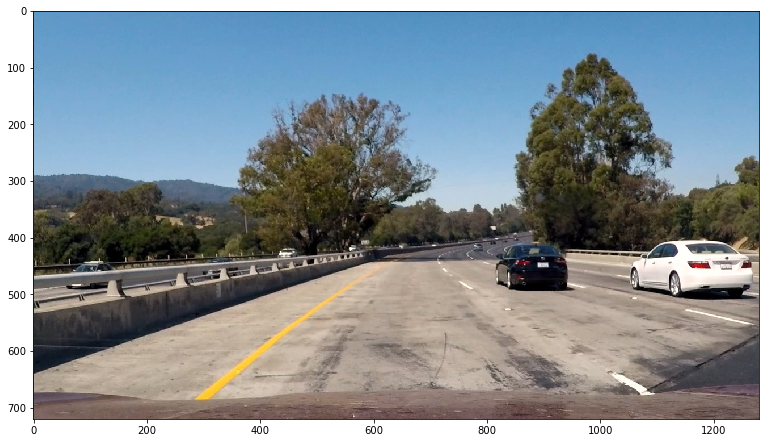

In [71]:
image = cv2.cvtColor(cv2.imread('./test_images/test1.jpg'), cv2.COLOR_BGR2RGB)
#import matplotlib.image as mpimg
#image = mpimg.imread('./test_images/test1.jpg')
plt.figure(figsize=(13,13))
plt.imshow(image)
#print(image[0:5, 0:5])

blur_gray shape: (720, 1280, 3)


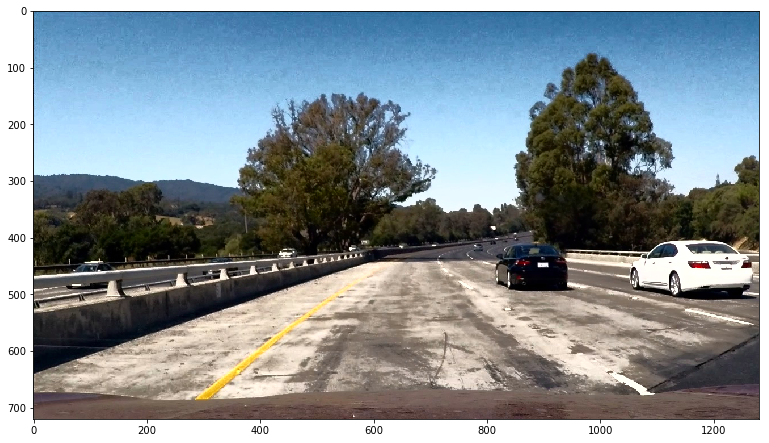

In [66]:
enhanced_img = enhanceContrastOfImage(image)
plt.figure(figsize=(13,13))
plt.imshow(enhanced_img, cmap='gray')
print("blur_gray shape:", enhanced_img.shape)

Gray scaled image is: <class 'numpy.ndarray'> with dimensions: (720, 1280)
[[253 254 247 226 155]
 [254 239 143 122 140]
 [246 134 126 120 114]
 [218 116 123 117 114]
 [148 140 123 117 105]]


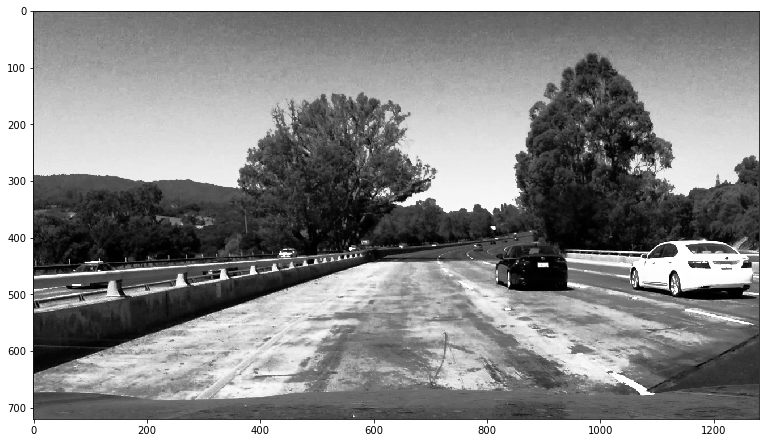

In [72]:
# Scale Image to gray
gray = grayscale(enhanced_img)
print('Gray scaled image is:', type(gray), 'with dimensions:', gray.shape)
plt.figure(figsize=(13,13))
plt.imshow(gray, cmap='gray')
print(gray[0:5, 0:5])
#mpimg.imsave("submission/image/gray.jpg", gray, cmap='gray')

blur_gray shape: (720, 1280)


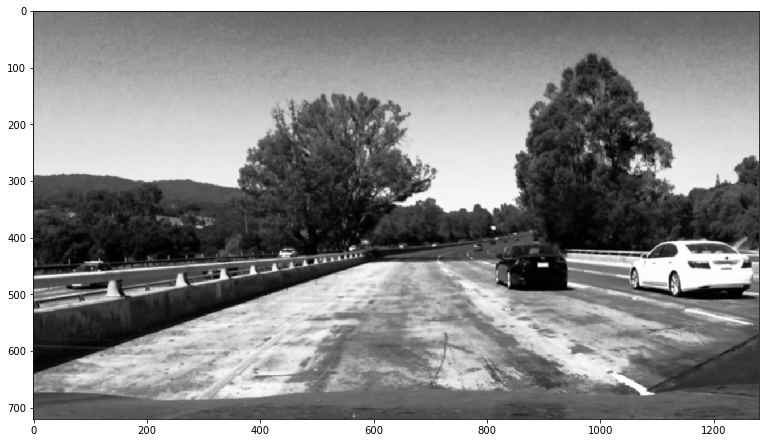

In [73]:
# Blur gray image
blur_gray = gaussian_blur(gray, 5)

plt.figure(figsize=(13,13))
plt.imshow(blur_gray, cmap='gray')
print("blur_gray shape:", blur_gray.shape)

#mpimg.imsave("submission/image/blur_gray.jpg", blur_gray, cmap='gray')

edges:  (720, 1280)


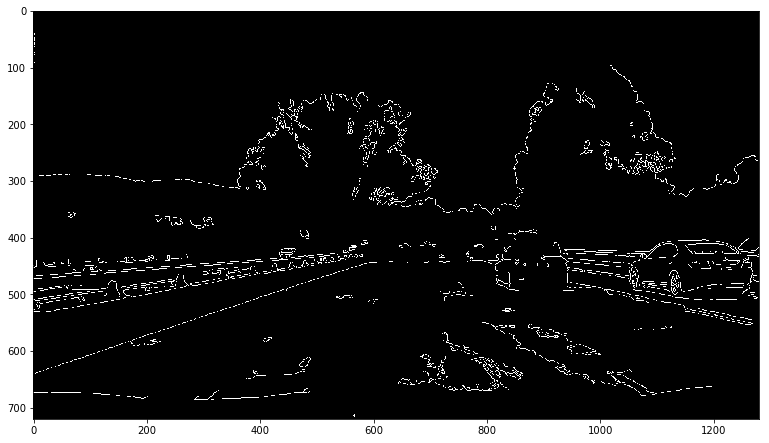

In [75]:
# canny edge
low_threshold = 60
high_threshold = low_threshold*
edges = canny(blur_gray, low_threshold, high_threshold)

plt.figure(figsize=(13,13))
plt.imshow(edges, cmap='Greys_r')
print("edges: ", edges.shape)

In [ ]:
# Mask
imshape = np.shape(image)

bottom_mask = 470
middle_mask = 60
width_center = imshape[1]*0.5
height_center = imshape[0]*0.59
height_bottom = imshape[0]*0.1

vertices = np.array([[(width_center-bottom_mask,imshape[0]-height_bottom),
                      (width_center-middle_mask, height_center),
                      (width_center+middle_mask, height_center),
                      (width_center+bottom_mask,imshape[0]-height_bottom)]], dtype=np.int32)

masked_img = region_of_interest(image, vertices)
plt.figure(figsize=(13,13))
plt.imshow(masked_img)
print("masked_edges shape: ", masked_img.shape)

#mpimg.imsave("submission/image/masked_edges.jpg", masked_edges, cmap='gray')

In [ ]:
# Mask
imshape = np.shape(image)

bottom_mask = 500
middle_mask = 100
width_center = imshape[1]*0.5
height_center = imshape[0]*0.62

vertices = np.array([[(width_center-bottom_mask,imshape[0]),
                      (width_center-middle_mask, height_center),
                      (width_center+middle_mask, height_center),
                      (width_center+bottom_mask,imshape[0])]], dtype=np.int32)

masked_edges = region_of_interest(edges, vertices)
plt.figure(figsize=(13,13))
plt.imshow(masked_edges, cmap='gray')
print("masked_edges shape: ", masked_edges.shape)

#mpimg.imsave("submission/image/masked_edges.jpg", masked_edges, cmap='gray')

# Perspective Transform

In [ ]:
def perspective_transform(image_data):
    img = np.copy(image_data)
    # work on defining perspective transformation area
    img_size = (img.shape[1], img.shape[0])
    bot_width = 0.45#0.4#0.8#0.76 # percent of bottom trapezoid height
    mid_width = 0.12#0.04#0.2#0.08 # percent of middle trapezoid height
    height_pct = 0.66#0.66#0.62 # percent for trapezoid height
    bottom_trim = 0.935#0.935 # percent from top to bottom to avoid car hood

    src = np.float32([[img.shape[1]*(0.5-mid_width/2), img.shape[0]*height_pct], [img.shape[1]*(0.5+mid_width/2), img.shape[0]*height_pct], 
                    [img.shape[1]*(0.5+bot_width/2), img.shape[0]*bottom_trim], [img.shape[1]*(0.5-bot_width/2),  img.shape[0]*bottom_trim]])
    
    offset = img_size[0]*0.25#0.3#0.15#0.25
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], [img_size[0]-offset, img_size[1]], [offset, img_size[1]]])
    
    # perform the transform
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    #write_name = './test_images/2. warped' + str(idx+1) + '.jpg'
    write_name = './test_images/2. warped.jpg'
    cv2.imwrite(write_name, warped)
    
test_img = cv2.imread('./test_images/test1.jpg')
perspective_transform(test_img)